# 图像复原实验

## 实验目的

试对下图进行图像复原。

![roof](roof.png)

## 实验环境
- OpenCV
- MatPlotLib
- NumPy
- SciPy

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2

## 实验原理

### 逆滤波

逆滤波是一种用于图像复原的频域方法，其理论基础建立在傅里叶变换的卷积定理上。在图像退化过程中，清晰图像 $ f(x, y) $ 与退化函数 $ h(x, y) $ 进行卷积，并受到噪声 $ n(x, y) $ 的影响，生成退化图像 $ g(x, y) $。在空间域中，该过程表示为：

$$g(x, y) = f(x, y) \ast h(x, y) + n(x, y)$$

通过傅里叶变换，将卷积转换为频域中的乘法关系：

$$G(u, v) = F(u, v) \cdot H(u, v) + N(u, v)$$

其中$ G(u, v) $、$ F(u, v) $、$ H(u, v) $ 和 $ N(u, v) $ 分别是退化图像、原始图像、退化函数和噪声的傅里叶变换。

理想情况下，假设噪声 $ N(u, v) $ 可忽略不计，图像复原的过程可以通过逆滤波器直接计算：

$$\hat{F}(u, v) = \frac{G(u, v)}{H(u, v)}$$

其中 $ \hat{F}(u, v) $ 是复原图像的傅里叶变换，复原图像 $ \hat{f}(x, y) $ 则通过反傅里叶变换得到：

$$\hat{f}(x, y) = \mathcal{F}^{-1} \left\{ \frac{G(u, v)}{H(u, v)} \right\}$$

In [27]:
def inverse_filter(blurred_image: np.ndarray, degen: np.ndarray, epsilon: float = 1e-8) -> np.ndarray:
    # 对图像和 PSF 进行傅里叶变换
    G = fft2(blurred_image)
    H = fft2(degen, s=blurred_image.shape)
    
    # 正则化项，避免放大噪声
    H_conj = np.conj(H)
    F_hat = G * H_conj / (H * H_conj + epsilon)
    
    # 通过反傅里叶变换恢复图像
    restored_image = np.abs(ifft2(F_hat))
    return restored_image


### 运动模糊退化模型

运动模糊是由相机或物体在拍摄过程中相对运动引起的，通常被建模为图像退化过程。也就是上式中的$ h(x, y) $ 是运动模糊的点扩散函数 (PSF)，描述运动模糊的特性。

在运动模糊中，点扩散函数 $ h(x, y) $ 通常由以下两个因素决定：
1. **运动方向**：描述了运动的角度或方向。
2. **运动长度**：描述了运动期间图像上的位移，即模糊的程度。

运动模糊的点扩散函数 $ h(x, y) $ 具体形式可以基于运动模型来确定，常见的模型是线性运动模糊，它假设物体沿某个固定方向以恒定速度移动。可以这样表示：

In [28]:
def linear_psf(length: int, angle: int|float) -> np.ndarray:
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        psf[center, i] = 1
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)
    psf = cv2.warpAffine(psf, rotation_matrix, (length, length))
    psf /= psf.sum()
    return psf

又观察到像素的模糊长轴是45度方向，所以运动方向也是45度。45度的PSF可以直接表示为：

In [29]:
def linear45_psf(length):
    psf = np.eye(length)[::-1] / length
    return psf

在理想情况下，假设噪声可以忽略不计 ($ N(u, v) = 0 $)，我们可以通过以下公式进行复原：

$$F(u, v) = \frac{G(u, v)}{H(u, v)}$$

然后通过反傅里叶变换得到复原后的图像 $ f(x, y) $：

$$f(x, y) = \mathcal{F}^{-1} \left\{ F(u, v) \right\}$$

在实际情况中，图像中通常会存在噪声，这会影响复原效果。噪声会导致在高频分量处 $ H(u, v) $ 非常小的情况下，噪声 $ N(u, v) $ 被放大。因此，直接使用逆滤波可能会产生严重的噪声放大问题。为了解决这个问题，常用的方法是采用正则化技术，或者使用维纳滤波。

#### 维纳滤波复原

维纳滤波是一种更加鲁棒的复原方法，它在考虑噪声的同时进行图像复原。维纳滤波的公式为：

$$\hat{F}(u, v) = \frac{H^*(u, v)}{|H(u, v)|^2 + \frac{S_n(u, v)}{S_f(u, v)}} G(u, v)$$

其中$ \hat{F}(u, v) $ 是复原图像的傅里叶变换，$ S_n(u, v) $ 和 $ S_f(u, v) $ 分别是噪声和原始图像的功率谱密度。

通过引入信号与噪声的比值，维纳滤波能够在复原时平衡噪声和图像细节的保留，从而实现更好的复原效果。维纳滤波是一种频域方法，适用于处理带有噪声的运动模糊图像复原问题。

In [30]:
def wiener_filter(blurred_image, psf, K=0.01):
    # 对图像和 PSF 进行傅里叶变换
    G = fft2(blurred_image)
    H = fft2(psf, s=blurred_image.shape)
    
    # 维纳滤波公式
    H_conj = np.conj(H)
    F_hat = (H_conj / (H * H_conj + K)) * G
    
    # 通过反傅里叶变换恢复图像
    restored_image = np.abs(ifft2(F_hat))
    return restored_image

## 实验步骤

观察到图像的模糊是线性均匀的，模糊轨迹方向是45度的，考虑使用运动角度45度的线性运动模糊退化模型。并用维纳滤波复原，尝试不同的运动模糊长度：

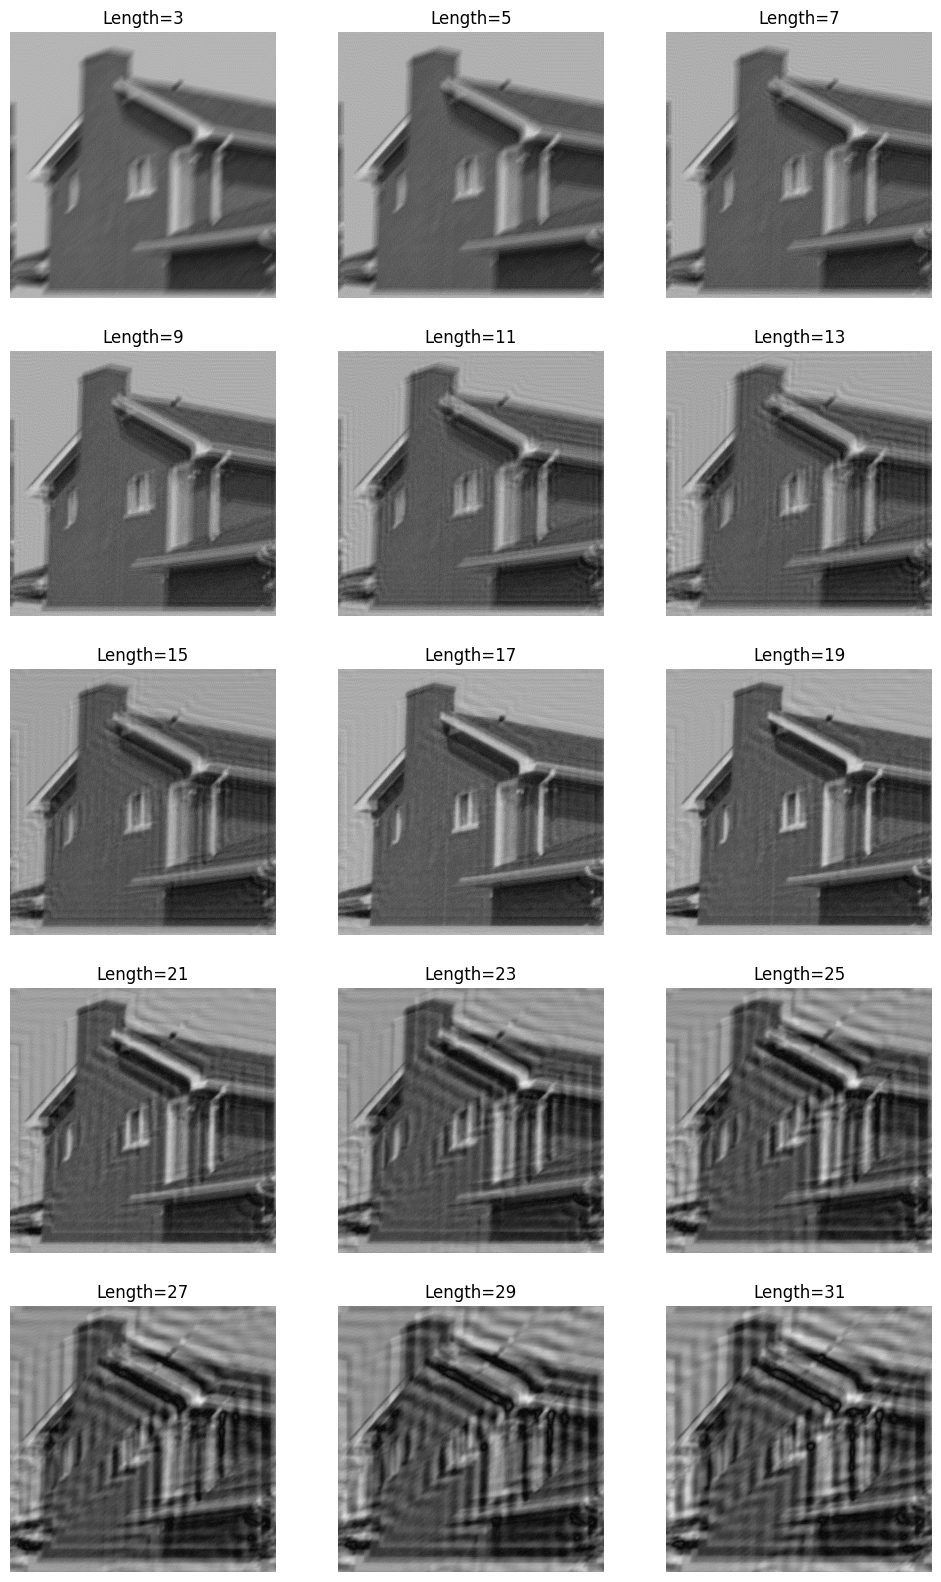

In [38]:
img = cv2.imread('roof.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 20))

for l in range(1, 16):
    psf = linear45_psf(2*l+1)
    restored_img = wiener_filter(img, psf)
    plt.subplot(5, 3, l)
    plt.imshow(restored_img, cmap='gray')
    plt.title(f'Length={2*l+1}')
    plt.axis('off')

plt.show()

可以看出模糊长度为17左右，复原效果最好。

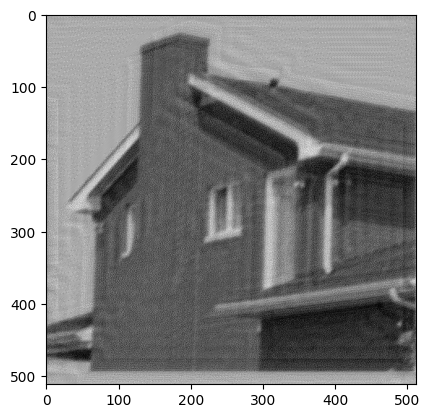

In [40]:
img = cv2.imread('roof.png', cv2.IMREAD_GRAYSCALE)
restored_img = wiener_filter(img, linear45_psf(17))
plt.imshow(restored_img, cmap='gray')